In [1]:
import pandas as pd
import os
import numpy as np
from dateutil.relativedelta import relativedelta

## Database Connection String and Data Read

In [2]:
# Load data (to be replaced by AWS connection string)
shelter_data_to_load = "Animal_Shelter_Intake_and_Outcome.csv"
shelter_data_df = pd.read_csv(shelter_data_to_load)
shelter_data_df.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,NaN,CAT,SIAMESE,BLACK/BLACK,Female,KITTN,NaN,K22-042204,CS05,A412797,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
1,NaN,CAT,DOMESTIC SH,GRAY/WHITE,Male,KITTN,06/24/2022,K22-042194,CA03,A412786,...,PHONE,NaN,NaN,UNKNOWN,NaN,COUNTY,NaN,NaN,NaN,1
2,NaN,CAT,SIAMESE,GRAY/BLACK,Female,KITTN,NaN,K22-042201,CS05,A412794,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
3,NaN,CAT,SIAMESE,GRAY/BLACK,Female,KITTN,NaN,K22-042202,CS05,A412795,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
4,NaN,CAT,DOMESTIC SH,BLACK,Female,SMALL,12/30/2020,K22-041790,SMM,A412222,...,FIELD,TRANSFER,WE CARE,UNKNOWN,HEALTHY,COUNTY,OUT OF COUNTY,94574.0,"94574(38.525993, -122.432854)",1


## Machine Learning Data Preprocessing

In [3]:
# Data exploration
col_det_df = shelter_data_df
columns_details_df = pd.DataFrame()
count = col_det_df.count()
null = col_det_df.isnull().sum()
unique = col_det_df.nunique()
dtype = col_det_df.dtypes
columns_details_df['count'] = count
columns_details_df['null'] = null
columns_details_df['unique'] = unique
columns_details_df['dtype'] = dtype
columns_details_df

,count,null,unique,dtype
Name,17291,6179,6320,object
Type,23470,0,3,object
Breed,23470,0,1005,object
Color,23470,0,332,object
Sex,23470,0,5,object
Size,23437,33,7,object
Date Of Birth,17618,5852,5442,object
Impound Number,23470,0,23470,object
Kennel Number,23462,8,161,object
Animal ID,23470,0,21200,object


In [4]:
# Animal type analysis
type_count = shelter_data_df.groupby(["Type"]).count()
type_count

,Name,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
Type,,,,,,,,,,,,,,,,,,,,,
CAT,4822,8330,8330,8330,8328,6066,8330,8327,8330,8330,...,8330,8268,8177,8330,8150,8330,6797,6797,6797,8330
DOG,11874,13242,13242,13242,13211,10958,13242,13237,13242,13242,...,13242,13140,13029,13242,13035,13242,11994,11934,11934,13242
OTHER,595,1898,1898,1898,1898,594,1898,1898,1898,1898,...,1898,1872,1767,1898,1758,1898,1384,1371,1371,1898


In [5]:
# Filter columns
filtered_df = shelter_data_df[['Type','Breed','Sex','Size','Date Of Birth','Intake Date',
                               'Days in Shelter','Intake Type','Intake Subtype',
                               'Outcome Type','Intake Condition','Intake Jurisdiction']]

# Filter Animal Type: 'CAT' and 'DOG'
filtered_df = filtered_df[filtered_df['Type'] != "OTHER"]
# filtered_df = filtered_df[filtered_df['Type'] == "CAT"]
# filtered_df = filtered_df[filtered_df['Type'] == "DOG"]

# Change column name
filtered_df = filtered_df.rename(columns={'Type': 'Animal Type'})

# Group Breed
filtered_df.loc[filtered_df['Breed'].str.contains('MIX'), 'Breed'] = 'MIX'
filtered_df.loc[filtered_df['Breed'].str.contains('/'), 'Breed'] = 'MIX'
filtered_df.loc[~filtered_df['Breed'].str.contains('MIX'), 'Breed'] = 'PURE'

# Group ML target classes
# filtered_df['Outcome Type'].replace({'ADOPTION':'ADOPTION RETURN','RETURN TO OWNER':'ADOPTION RETURN'},inplace=True)

# Group other classes
filtered_df['Sex'].replace({'Spayed':'Spayed or Neutered','Neutered':'Spayed or Neutered'},inplace=True)
filtered_df['Intake Subtype'].replace({'BORN_HERE':'OTHER','COMM CAT':'OTHER','FIELD':'FIELD',
                                       'FIELD_OS':'FIELD','FIELD_RETURN TO OWNER':'FIELD','FLD_ABAND':'FIELD',
                                       'FLD_ARREST':'FIELD','FLD_CORONR':'FIELD','FLD_CRUEL':'FIELD',
                                       'FLD_EMERGE':'FIELD','FLD_EVICT':'FIELD','FLD_HOSPTL':'FIELD',
                                       'FLD_INVEST':'FIELD','FLD_LIVSTK':'FIELD','FLD_OWNED':'FIELD',
                                       'FLD_STRAY':'FIELD','MUN_SHELT':'OTHER','OVER THE COUNTER':'OVER THE COUNTER',
                                       'OVER THE COUNTER_ARREST':'OVER THE COUNTER','OVER THE COUNTER_CORONR':'OVER THE COUNTER','OVER THE COUNTER_EVICT':'OVER THE COUNTER',
                                       'OVER THE COUNTER_OS':'OVER THE COUNTER','OVER THE COUNTER_OWNED':'OVER THE COUNTER','OVER THE COUNTER_RETURN TO OWNER':'OVER THE COUNTER',
                                       'OVER THE COUNTER_STRAY':'OVER THE COUNTER','PHONE':'OTHER','PRIV_SHELT':'OTHER',
                                       'RESCUE_GRP':'OTHER','VET_HOSP':'OTHER'
                                      },inplace=True)
# Drop NaN
filtered_df = filtered_df.dropna()

# Change dates dtype
filtered_df[['Date Of Birth','Intake Date']] = filtered_df[['Date Of Birth','Intake Date']].apply(pd.to_datetime)

# Calculate 'Age at intake time' and drop
filtered_df['Age at Intake'] = filtered_df['Intake Date'] - filtered_df['Date Of Birth']
filtered_df['Age at Intake'] = filtered_df['Age at Intake']/np.timedelta64(1, 'Y')

# Remove negative values in 'Age at intake time'
filtered_df = filtered_df[filtered_df['Age at Intake'] > 0]

# Change 'Days in shelter' dtype and format
filtered_df['Days in Shelter'] = filtered_df['Days in Shelter'].str.replace(',', '').astype(float)

# Drop days in shelter = 0
filtered_df = filtered_df[filtered_df['Days in Shelter'] > 0]
filtered_df.head()

,Animal Type,Breed,Sex,Size,Date Of Birth,Intake Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Age at Intake
4,CAT,PURE,Female,SMALL,2020-12-30,2022-06-30,41.0,STRAY,FIELD,TRANSFER,UNKNOWN,COUNTY,1.497635
6,CAT,PURE,Male,SMALL,2015-08-03,2022-08-03,6.0,STRAY,OVER THE COUNTER,TRANSFER,UNKNOWN,SANTA ROSA,7.000828
13,DOG,PURE,Male,MED,2021-10-11,2022-04-11,120.0,QUARANTINE,FIELD,RETURN TO OWNER,UNKNOWN,SANTA ROSA,0.498299
14,DOG,PURE,Male,SMALL,2021-08-29,2022-08-04,5.0,CONFISCATE,FIELD,RETURN TO OWNER,UNKNOWN,SANTA ROSA,0.930888
21,DOG,MIX,Male,MED,2021-03-26,2022-06-25,4.0,STRAY,OTHER,RETURN TO OWNER,UNKNOWN,SANTA ROSA,1.248486


In [6]:
# Drop dates columns
filtered_df = filtered_df.drop('Date Of Birth', axis=1)
filtered_df = filtered_df.drop('Intake Date', axis=1)
filtered_df.head()

,Animal Type,Breed,Sex,Size,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Age at Intake
4,CAT,PURE,Female,SMALL,41.0,STRAY,FIELD,TRANSFER,UNKNOWN,COUNTY,1.497635
6,CAT,PURE,Male,SMALL,6.0,STRAY,OVER THE COUNTER,TRANSFER,UNKNOWN,SANTA ROSA,7.000828
13,DOG,PURE,Male,MED,120.0,QUARANTINE,FIELD,RETURN TO OWNER,UNKNOWN,SANTA ROSA,0.498299
14,DOG,PURE,Male,SMALL,5.0,CONFISCATE,FIELD,RETURN TO OWNER,UNKNOWN,SANTA ROSA,0.930888
21,DOG,MIX,Male,MED,4.0,STRAY,OTHER,RETURN TO OWNER,UNKNOWN,SANTA ROSA,1.248486


In [7]:
# Data analysis
col_det_df = filtered_df
cleaned_columns_details_df = pd.DataFrame()
count = col_det_df.count()
null = col_det_df.isnull().sum()
unique = col_det_df.nunique()
dtype = col_det_df.dtypes
cleaned_columns_details_df['count'] = count
cleaned_columns_details_df['null'] = null
cleaned_columns_details_df['unique'] = unique
cleaned_columns_details_df['dtype'] = dtype
cleaned_columns_details_df

,count,null,unique,dtype
Animal Type,14355,0,2,object
Breed,14355,0,2,object
Sex,14355,0,4,object
Size,14355,0,7,object
Days in Shelter,14355,0,249,float64
Intake Type,14355,0,6,object
Intake Subtype,14355,0,3,object
Outcome Type,14355,0,8,object
Intake Condition,14355,0,5,object
Intake Jurisdiction,14355,0,13,object


In [8]:
# Generate a categorical variable list
filtered_df_cat = filtered_df.dtypes[filtered_df.dtypes == "object"].index.tolist()
filtered_df_cat

['Animal Type',
 'Breed',
 'Sex',
 'Size',
 'Intake Type',
 'Intake Subtype',
 'Outcome Type',
 'Intake Condition',
 'Intake Jurisdiction']

In [9]:
# Check the number of unique values in each column
filtered_df[filtered_df_cat].nunique()

Animal Type             2
Breed                   2
Sex                     4
Size                    7
Intake Type             6
Intake Subtype          3
Outcome Type            8
Intake Condition        5
Intake Jurisdiction    13
dtype: int64

In [10]:
from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(filtered_df[filtered_df_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(filtered_df_cat)
encode_df.head()

,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Breed_PURE,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,...,Intake Jurisdiction_*PETALUMA,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Merge one-hot encoded features and drop the originals
filtered_df = filtered_df.merge(encode_df,left_index=True, right_index=True)
filtered_encoded_df = filtered_df.drop(filtered_df_cat,1)
filtered_encoded_df.head()

C:\Users\fernanm\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Days in Shelter,Age at Intake,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Breed_PURE,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,...,Intake Jurisdiction_*PETALUMA,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN
4,41.0,1.497635,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,6.0,7.000828,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13,120.0,0.498299,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14,5.0,0.930888,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21,4.0,1.248486,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
filtered_encoded_df.columns

Index(['Days in Shelter', 'Age at Intake', 'Animal Type_CAT',
       'Animal Type_DOG', 'Breed_MIX', 'Breed_PURE', 'Sex_Female', 'Sex_Male',
       'Sex_Spayed or Neutered', 'Sex_Unknown', 'Size_KITTN', 'Size_LARGE',
       'Size_MED', 'Size_PUPPY', 'Size_SMALL', 'Size_TOY', 'Size_X-LRG',
       'Intake Type_ADOPTION RETURN', 'Intake Type_CONFISCATE',
       'Intake Type_OWNER SURRENDER', 'Intake Type_QUARANTINE',
       'Intake Type_STRAY', 'Intake Type_TRANSFER', 'Intake Subtype_FIELD',
       'Intake Subtype_OTHER', 'Intake Subtype_OVER THE COUNTER',
       'Outcome Type_ADOPTION', 'Outcome Type_DIED', 'Outcome Type_DISPOSAL',
       'Outcome Type_ESCAPED/STOLEN', 'Outcome Type_EUTHANIZE',
       'Outcome Type_RETURN TO OWNER', 'Outcome Type_RTOS',
       'Outcome Type_TRANSFER', 'Intake Condition_HEALTHY',
       'Intake Condition_TREATABLE/MANAGEABLE',
       'Intake Condition_TREATABLE/REHAB', 'Intake Condition_UNKNOWN',
       'Intake Condition_UNTREATABLE', 'Intake Jurisdiction

In [13]:
# Drop other outcome types
# filtered_encoded_df = filtered_encoded_df.drop(['Outcome Type_DIED','Outcome Type_DISPOSAL',
#                                                 'Outcome Type_ESCAPED/STOLEN','Outcome Type_EUTHANIZE',
#                                                 'Outcome Type_RTOS','Outcome Type_TRANSFER'], axis=1)


filtered_encoded_df = filtered_encoded_df.drop(['Outcome Type_DIED','Outcome Type_DISPOSAL','Outcome Type_RETURN TO OWNER',
                                                'Outcome Type_ESCAPED/STOLEN','Outcome Type_EUTHANIZE',
                                                'Outcome Type_RTOS','Outcome Type_TRANSFER'], axis=1)

# Drop other columns to avoid ulticollinearity
filtered_encoded_df = filtered_encoded_df.drop(['Breed_PURE'], axis=1)
filtered_encoded_df = filtered_encoded_df.drop(['Sex_Female','Sex_Male','Sex_Unknown'], axis=1)

In [14]:
# Copy columns to be scaled
scale_df = filtered_encoded_df[['Days in Shelter', 'Age at Intake']].copy()
scale_df.head()

,Days in Shelter,Age at Intake
4,41.0,1.497635
6,6.0,7.000828
13,120.0,0.498299
14,5.0,0.930888
21,4.0,1.248486


In [15]:
# Describe columns to be scaled
scale_df.describe()

,Days in Shelter,Age at Intake
count,8771.000000,8771.000000
mean,23.114354,3.323964
std,37.818546,3.827068
min,1.000000,0.002738
25%,4.000000,0.412055
50%,14.000000,1.952128
75%,29.000000,4.999418
max,891.000000,20.000411


In [16]:
# Create the Scaler instance
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# scaler = RobustScaler()
scaler = StandardScaler()

In [17]:
# Fit the Scaler
scaler.fit(scale_df)

StandardScaler()

In [18]:
# Scale the data
scaled_data = scaler.transform(scale_df)

In [19]:
# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, index=scale_df.index, columns=scale_df.columns)
transformed_scaled_data.head()

,Days in Shelter,Age at Intake
4,0.472960,-0.477241
6,-0.452564,0.960807
13,2.562001,-0.738379
14,-0.479008,-0.625338
21,-0.505452,-0.542347


In [20]:
filtered_encoded_scaled_df = filtered_encoded_df.merge(transformed_scaled_data, how = 'outer', 
                                                left_index = True, right_index = True)
filtered_encoded_scaled_df.head()

,Days in Shelter_x,Age at Intake_x,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_PUPPY,...,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
4,41.0,1.497635,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.472960,-0.477241
6,6.0,7.000828,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.452564,0.960807
13,120.0,0.498299,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.562001,-0.738379
14,5.0,0.930888,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.479008,-0.625338
21,4.0,1.248486,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.505452,-0.542347


In [21]:
filtered_encoded_scaled_df = filtered_encoded_scaled_df.drop(['Days in Shelter_x','Age at Intake_x'], axis=1)
filtered_encoded_scaled_df.head()

,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.472960,-0.477241
6,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.452564,0.960807
13,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.562001,-0.738379
14,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.479008,-0.625338
21,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.505452,-0.542347


In [22]:
# Export CSV or create testing df
# filtered_encoded_scaled_df.to_csv('sonoma_shelter_ML_test.csv',index=False)
df = filtered_encoded_scaled_df.copy()
df = df.reset_index(drop=True)
df.head(5)

,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.472960,-0.477241
1,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.452564,0.960807
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.562001,-0.738379
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.479008,-0.625338
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.505452,-0.542347


## PyCaret

In [23]:
import pycaret
from pycaret.regression import *

In [24]:
data = df.sample(frac=0.9, random_state=786).reset_index(drop=True)
data_unseen = df.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (7894, 41)
Unseen Data For Predictions: (877, 41)


In [25]:
# exp_reg101 = setup(data = df,
#                    target = 'Outcome Type_ADOPTION RETURN',
#                    ignore_features = ['listing image','listing url','full address','zipcode']) 

exp_reg101 = setup(data = df,
#                    target = 'Outcome Type_ADOPTION RETURN')

# exp_reg101 = setup(data = df,
                   target = 'Outcome Type_ADOPTION')

,Description,Value
0,session_id,7010
1,Target,Outcome Type_ADOPTION
2,Original Data,"(8771, 41)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,38
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6139, 38)"


In [26]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2850,0.1355,0.3680,0.4502,0.0000,0.3117,0.2290
br,Bayesian Ridge,0.3305,0.1480,0.3847,0.3994,0.0000,0.3327,0.0170
ridge,Ridge Regression,0.3303,0.1483,0.3850,0.3984,0.0000,0.3317,0.0170
lr,Linear Regression,0.3306,0.1487,0.3855,0.3967,0.0000,0.3327,0.8930
huber,Huber Regressor,0.3225,0.1508,0.3882,0.3881,0.0000,0.2940,0.1420
rf,Random Forest Regressor,0.2708,0.1533,0.3913,0.3779,0.0000,0.3076,0.5220
ada,AdaBoost Regressor,0.3483,0.1638,0.4047,0.3354,0.0000,0.4104,0.0530
omp,Orthogonal Matching Pursuit,0.3559,0.1660,0.4074,0.3264,0.0000,0.3727,0.0130
et,Extra Trees Regressor,0.2637,0.1837,0.4284,0.2544,0.0000,0.3006,0.4870
par,Passive Aggressive Regressor,0.3599,0.1884,0.4336,0.2361,0.0000,0.3806,0.0160


In [27]:
model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2852,0.1404,0.3747,0.4325,-0.0000,0.3344
1,0.2752,0.1266,0.3558,0.4844,-0.0000,0.3085
2,0.2820,0.1354,0.3679,0.4385,-0.0000,0.3036
3,0.2934,0.1452,0.3811,0.4051,-0.0000,0.3119
4,0.2744,0.1222,0.3496,0.5101,-0.0000,0.3121
5,0.2853,0.1347,0.3670,0.4582,-0.0000,0.3118
6,0.2913,0.1401,0.3742,0.4366,-0.0000,0.3057
7,0.2905,0.1427,0.3777,0.4162,-0.0000,0.3112
8,0.2971,0.1407,0.3750,0.4333,-0.0000,0.3219


In [28]:
tuned_gbr = tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3039,0.1421,0.3769,0.4258,-0.0000,0.3623
1,0.2928,0.1290,0.3592,0.4745,-0.0000,0.3370
2,0.2987,0.1366,0.3696,0.4333,-0.0000,0.3324
3,0.3132,0.1466,0.3829,0.3994,-0.0000,0.3426
4,0.2911,0.1250,0.3535,0.4991,-0.0000,0.3375
5,0.3018,0.1347,0.3670,0.4581,-0.0000,0.3369
6,0.3045,0.1400,0.3741,0.4370,-0.0000,0.3298
7,0.3062,0.1431,0.3783,0.4143,-0.0000,0.3385
8,0.3126,0.1426,0.3776,0.4254,-0.0000,0.3450


In [29]:
# plot_model(tuned_gbr)

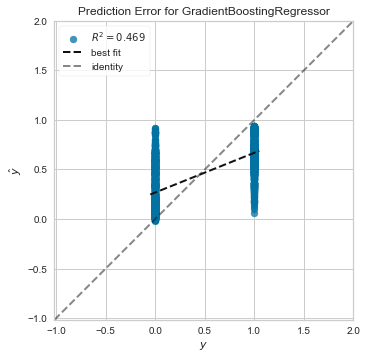

In [30]:
plot_model(tuned_gbr, plot = 'error')

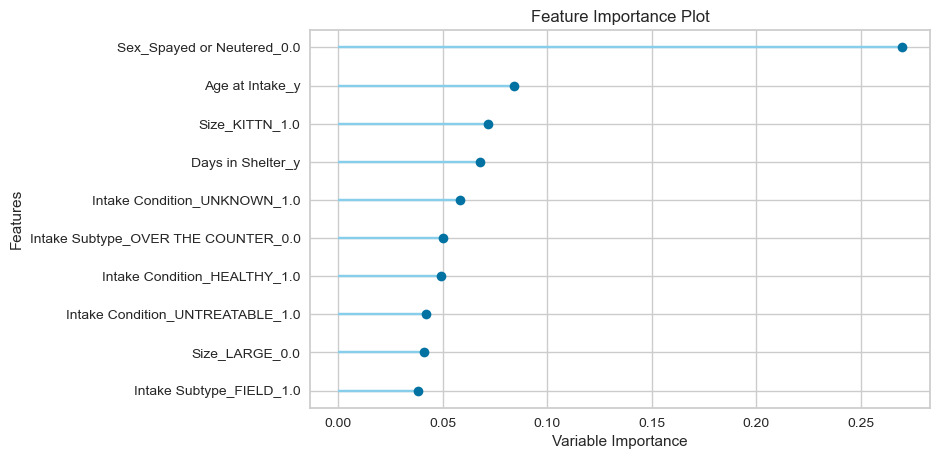

In [31]:
plot_model(tuned_gbr, plot='feature')

In [32]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
unseen_predictions = predict_model(tuned_gbr, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2855,0.1215,0.3486,0.5030,0.2471,0.3214


,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y,Label
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.320347,-0.826379,0.810986
1,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.003024,0.699669,0.486583
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.584782,0.478596,0.329821
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.531895,0.174531,0.458850
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.188129,0.745458,0.305800


In [34]:
# unseen_predictions.to_csv('predictions.csv',index=False)
# unseen_predictions.to_csv('adoptions.csv',index=False)

## Gradient Boosting Regressor

#### Define features and Split the Data into Training and Testing

In [35]:
# Define features
X = df.copy()
# X = X.drop('Outcome Type_ADOPTION RETURN', axis=1)
X = X.drop('Outcome Type_ADOPTION', axis=1)
X.head()
# Create our target
# y = df['Outcome Type_ADOPTION RETURN']
y = df['Outcome Type_ADOPTION']

In [36]:
X.describe()

,Animal Type_CAT,Animal Type_DOG,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*TRIBAL RESV,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
count,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,...,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8771.000000,8.771000e+03,8.771000e+03
mean,0.371793,0.628207,0.304070,0.772204,0.188690,0.173526,0.193593,0.048797,0.329951,0.058716,...,0.000798,0.001140,0.000798,0.060084,0.429370,0.009235,0.489226,0.000228,-6.302361e-17,-7.173698e-17
std,0.483311,0.483311,0.460039,0.419434,0.391284,0.378723,0.395136,0.215456,0.470222,0.235106,...,0.028241,0.033748,0.028241,0.237657,0.495014,0.095659,0.499912,0.015100,1.000057e+00,1.000057e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.847823e-01,-8.678748e-01
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.054516e-01,-7.609155e-01
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.410160e-01,-3.584767e-01
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.556374e-01,4.378154e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.294999e+01,4.357748e+00


In [37]:
# Check the balance of our target values
y.value_counts()

0.0    4868
1.0    3903
Name: Outcome Type_ADOPTION, dtype: int64

In [38]:
# Split the Data into Training and Testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.shape

(6578, 40)

#### Run GBR

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
# Test model parameters and loop learning rates
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    regressor = GradientBoostingRegressor(n_estimators=100,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            criterion = 'mse',
                                            random_state=0)
    # Fit the model
    regressor.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        regressor.score(
            X_train,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        regressor.score(
            X_test,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.443
Accuracy score (validation): 0.440

Learning rate:  0.1
Accuracy score (training): 0.468
Accuracy score (validation): 0.456

Learning rate:  0.25
Accuracy score (training): 0.492
Accuracy score (validation): 0.454

Learning rate:  0.5
Accuracy score (training): 0.511
Accuracy score (validation): 0.448

Learning rate:  0.75
Accuracy score (training): 0.527
Accuracy score (validation): 0.439

Learning rate:  1
Accuracy score (training): 0.534
Accuracy score (validation): 0.433



In [40]:
# Choose parameters and create regessor
regressor_params = {'n_estimators': 100,
                    'learning_rate': 0.25,
                    'max_features': 5,
                    'max_depth': 3,
                    'criterion': 'mse',
                    'random_state': 0}

regressor = GradientBoostingRegressor(**regressor_params)
# Fit the model
regressor.fit(X_train, y_train)
# Make Prediction
predictions = regressor.predict(X_test)
# predictions

#### Evaluate model

In [41]:
# Print Coefficient of determination R2
print("Model Accuracy: %.3f" % regressor.score(X_test, y_test))
# Print the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, regressor.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.454
The mean squared error (MSE) on test set: 0.1347


In [42]:
# Sort the features by their importance
features_imp_df = pd.DataFrame(sorted(zip(regressor.feature_importances_, X.columns), reverse=True))
features_imp_df.columns = ['%', 'Feature']
features_imp_df.head(10)

,%,Feature
0,0.341589,Sex_Spayed or Neutered
1,0.104975,Intake Subtype_FIELD
2,0.093216,Intake Condition_UNKNOWN
3,0.072929,Size_KITTN
4,0.061557,Intake Condition_UNTREATABLE
5,0.060376,Animal Type_CAT
6,0.053129,Intake Condition_HEALTHY
7,0.020967,Intake Condition_TREATABLE/REHAB
8,0.020621,Size_PUPPY
9,0.019331,Size_LARGE


In [43]:
# Label manual analysis
pred_df = pd.DataFrame(predictions)
pred_df.columns=['Label']
target_df = pd.DataFrame(y_test).reset_index(drop=True)
target_df.columns=['Target']
label_analysis_df = target_df.merge(pred_df, how = 'outer', left_index = True, right_index = True)
label_analysis_df['Row Count'] = 1
label_analysis_df.head()

,Target,Label,Row Count
0,0.0,-0.087706,1
1,0.0,0.135342,1
2,1.0,0.759150,1
3,0.0,-0.026010,1
4,1.0,0.454511,1


In [44]:
label_summary = label_analysis_df.groupby(["Target"]).sum()
label_summary['%'] = label_summary['Label'] / label_summary['Row Count']
label_summary

,Label,Row Count,%
Target,,,
0.0,292.707705,1217,0.240516
1.0,680.995981,976,0.697742


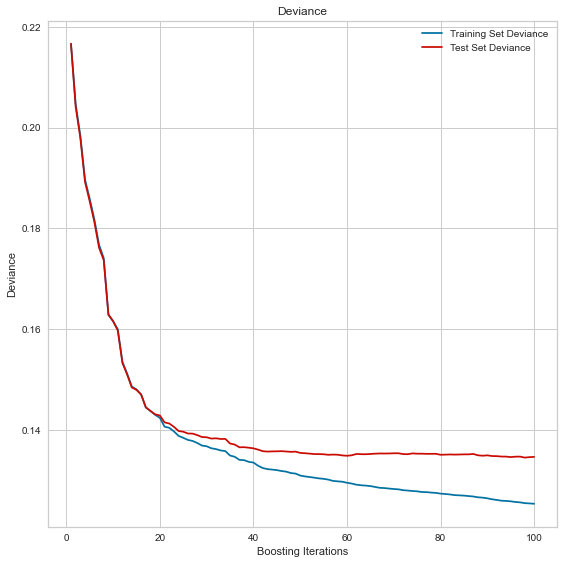

In [45]:
from matplotlib import pyplot as plt
# Assessing the training and test deviance (loss)
test_score = np.zeros((regressor_params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(regressor.staged_predict(X_test)):
    test_score[i] = regressor.loss_(y_test, y_pred)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(regressor_params['n_estimators']) + 1, regressor.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(regressor_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()